# Introduction to Probabilistic Graphical Models
## Practical Session 2
### Author: Xiang Yu, Email: shawnxiangyu@yahoo.com

In [12]:
%matplotlib inline
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import networkx as nx
import pyparsing
from IPython.display import Math
import copy
import math
## we first run the code with the warning enabled, if no error of relevant warning is to be found, 
## we disable the warning then
# import warnings
# warnings.filterwarnings("ignore")

In [13]:
# choose a large font size by default and use tex for math
fontsize = 18
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': True}
plt.rcParams.update(params)

In [14]:
math_pi = math.pi

#### Question 1

We need to compute    
$$
\large \gamma_i(x) = \frac{\pi_i \mathcal{N}(x;\mu_i, \Sigma_i)}{ \sum_{j=1}^K \pi_j \mathcal{N}(x;\mu_j, \Sigma_j)}
$$
We could take log on both side, then 
$$
\large \log\gamma_i(x) = \log(\pi_i \mathcal{N}(x;\mu_i, \Sigma_i)) - \log(\sum_{j=1}^K \pi_j \mathcal{N}(x;\mu_j, \Sigma_j))
$$

where $\log(\sum\pi_j\mathcal{N_j})$ could be calculated with the stable method in the Practical Session 1.I.e. 


\begin{align}
\large \log(\sum\pi_j\mathcal{N_j}) 
 &= \large log\sum_{i=1}^I \pi_j \kappa_j\exp(v_j) \\
 & = \large \log\sum_{j=1}^I \pi_j\kappa_j \exp(v_j- V_{max} + V_{max}) \\
  & = \large \log\sum_{j=1}^I \pi_j\kappa_j\exp(v_j- V_{max}) \exp(V_{max}) \\
 & = \large V_{max} + \log\sum_{j=1}^I \pi_j\kappa_j\exp(v_j- V_{max})
\end{align}



\begin{align}
\large \mathcal{N_j} 
 = \large \mathcal{N_j}(x;\boldsymbol\mu_j, \boldsymbol\Sigma_j)  = \kappa_j\exp(v_j) = \frac{\exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu_j})^\mathrm{T}{\boldsymbol\Sigma_j}^{-1}({\mathbf x}-{\boldsymbol\mu_j})\right)}{\sqrt{(2\pi)^k|\boldsymbol\Sigma_j|}}
\end{align}

where
$$ \large v_j = -\frac 1 2 ({\mathbf x}-{\boldsymbol\mu_j})^\mathrm{T}{\boldsymbol\Sigma_j}^{-1}({\mathbf x}-{\boldsymbol\mu_j}),  V_{max} = \max_{j} v_j $$
and 
$$ \large \kappa_j = \frac{1}{\sqrt{(2\pi)^k|\boldsymbol\Sigma_j|}} $$



### We derive the calculation in more details: 
$$
\large \log\gamma_i(x) = \log(\pi_i \mathcal{N}(x;\mu_i, \Sigma_i)) - \log(\sum_{j=1}^K \pi_j \mathcal{N}(x;\mu_j, \Sigma_j))
$$

\begin{align}
\large \log(\pi_i \mathcal{N}(x;\mu_i, \Sigma_i)) 
&=  \large \log (\pi_i \frac{\exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu_j})^\mathrm{T}{\boldsymbol\Sigma_j}^{-1}({\mathbf x}-{\boldsymbol\mu_j})\right)}{\sqrt{(2\pi)^k|\boldsymbol\Sigma_j|}}) \\
\\
&= \large V_{max} + \log \pi_j\kappa_j\exp(v_j- V_{max})
\end{align} 



And
\begin{align}
\large \log(\sum_{j=1}^K \pi_j \mathcal{N}(x;\mu_j, \Sigma_j)) = \large V_{max} + \log\sum_{j=1}^I \pi_j\kappa_j\exp(v_j- V_{max})
\end{align}



#### Question 2

### Step 1: initialize $\Pi, \mu, \Sigma$
### Step 2: calculate gamma:  $\gamma$
### Step 3: update $\Pi, \mu, \Sigma$
### Step 4: check stop criterion, if not stopping, go to step 2

In [68]:
# step 2: calculate (log) gamma
def cal_vj (x, u, sigma): 
    # xi = [x1i, x2i], ui = [u1i, u2i]
    # x and u : n * 1 vector
    # sigma: n * n
    
    diff = x - u
    sigma_inv = np.linalg.inv(sigma)
    # the inverse calculation is heavy, and could be improved with some other more robust numerical methods
    return - diff.dot(sigma_inv).dot(diff) / 2
    
def cal_kappa(K, sigmas, nr_kappa): 
    # calculate kappas for all K
    
    if nr_kappa == 1: 
        sigma_i_det = np.linalg.det(sigmas)
        kappas = 1 / ((2* math_pi) ** (K / 2) *  sigma_i_det  ** 0.5 ) 
    else:     
        kappas = np.zeros((nr_kappa, 1))
        for i in np.arange(nr_kappa): 
            sigma_i_det = np.linalg.det(sigmas[i])
            kappas[i] = 1 / ((2* math_pi) ** (K / 2) *  sigma_i_det  ** 0.5 ) 
    return kappas    


def cal_log_gamma_k(k, ps, us, sigmas, xs, j):

    xj = xs[j]
    # xj: one sample. The total number of sample is N
    # k: the index of the Guassian Distribution, total number of GD is K
    
    vjs = np.zeros((N,1))
#     for kj in np.arange(K):        
#         vjs[kj] = cal_vj(xj, us[kj], sigmas[kj])
        
    for kj in np.arange(N):        
        vjs[kj] = cal_vj(xs[kj], us[k], sigmas[k])    
        
    
    vjs_max = np.max(vjs)  # maximum of vj for all of the k-th Gaussian Distribution
    
    sigma_k_det = np.linalg.det(sigmas[k])
    
    #kappa_ks = cal_kappa(K, sigmas, K)  # kappa for all K

    # nominator part:
    # log_nominator = vjs_max + np.log(ps[k] * kappa_ks[k] * np.exp(vjs[j] - vjs_max))
    
    log_nominator = np.log(ps[k]) - (K * np.log(2* math_pi) + np.log(sigma_k_det)) / 2 + vjs[j]
    
    #print (np.multiply(ps,kappa_ks), '\n', kappa_ks, '\n', np.exp(vjs[k] - vjs_max))
    
    #log_denominator = vjs_max  + np.log(np.sum(np.multiply(ps,kappa_ks) * np.exp(vjs[j] - vjs_max)))
    
    log_denominator = np.log(ps[k]) - (K * np.log(2* math_pi) + np.log(sigma_k_det)) / 2 + vjs_max - np.log(np.sum(np.exp(vjs - vjs_max)))
    
    
    log_gamma_k = log_nominator - log_denominator 
    
    return log_gamma_k 
        

def cal_log_gamma_ks(K, ps, us, sigmas, xs): 
    # N: number of sample data
    log_gamma_ks = np.zeros((K,N))
    
    for kj in np.arange(K): 
        for j in np.arange(N): 
            log_gamma_ks[kj, j] = cal_log_gamma_k(kj, ps, us, sigmas, xs, j)
            
    return  log_gamma_ks      


In [69]:
ps = pi_para.copy()
us = us_para.copy()
sigmas= sgs.copy()
xs = xs_nl.copy()

log_gamma_ks = cal_log_gamma_ks(K, ps, us, sigmas, xs)

In [70]:
print (log_gamma_ks)

[[4.95437128 5.53188012 5.80154276 ... 5.92657964 5.46485802 5.2552215 ]
 [4.95437128 5.53188012 5.80154276 ... 5.92657964 5.46485802 5.2552215 ]
 [4.95437128 5.53188012 5.80154276 ... 5.92657964 5.46485802 5.2552215 ]]


In [72]:
k0g0 = cal_log_gamma_k(0, ps, us, sigmas, xs, 0)
k0g1 = cal_log_gamma_k(0, ps, us, sigmas, xs, 1)
k1g0 = cal_log_gamma_k(1, ps, us, sigmas, xs, 0)
k1g1 = cal_log_gamma_k(1, ps, us, sigmas, xs, 1)

print (k0g0, k0g1, k1g0, k1g1)

[4.95437128] [5.53188012] [4.95437128] [5.53188012]


In [32]:
def update_mu_sigma_pi(log_gamma_ks, K, ps, us, sigmas, xs):
    ps_new = ps.copy()
    us_new = us.copy()
    sigmas_new = sigmas.copy()
    
    for kj in np.arange(K): # iteration over all Gaussian
        
        sum_gamma_k = np.sum(np.exp(log_gamma_ks[kj,:]))
        #print (xs.T* np.exp(log_gamma_ks[kj,:]))
        us_new[kj,:] = np.sum(xs.T* np.exp(log_gamma_ks[kj,:]), axis=1) / sum_gamma_k 
        #print (uj, np.sum(np.exp(log_gamma_ks[kj,:]))) #us_new[kj,:] 
        ps_new[kj] = sum_gamma_k / N
        
        diff = xs - us_new[kj,:]
        
        sigma_nominater = [np.exp(log_gamma_ks[kj,i]) *np.outer(diff[i,:], diff[i,:]) for i in np.arange(N)]
        
        sigmas_new[kj,:] = np.sum(sigma_nominater, axis=0) / sum_gamma_k
                   
    return us_new, ps_new, sigmas_new



In [67]:
print (log_gamma_ks)

[[4.95437128 5.53188012 5.80154276 ... 5.92657964 5.46485802 5.2552215 ]
 [4.95437128 5.53188012 5.80154276 ... 5.92657964 5.46485802 5.2552215 ]
 [4.95437128 5.53188012 5.80154276 ... 5.92657964 5.46485802 5.2552215 ]]


In [ ]:
us_new, ps_new, sigmas_new = update_mu_sigma_pi(log_gamma_ks, K, ps, us, sigmas, xs)

In [40]:
k0g0 = cal_log_gamma_k(0, ps, us, sigmas, xs, 0)
k0g1 = cal_log_gamma_k(0, ps, us, sigmas, xs, 1)

print (k0g0, k0g1)

# print (log_gamma_ks)

# print (xs)

[-1.09861229] [-1.09861229]


In [43]:
vjs = np.zeros((N,1))
k = 0

for kj in np.arange(N):        
    vjs[kj] = cal_vj(xs[kj], us[k], sigmas[k]) 

In [59]:
k = 0
j = 0
vjs_max = np.max(vjs)  # maximum of vj for all of the k-th Gaussian Distribution

sigma_k_det = np.linalg.det(sigmas[k])

kappa_ks = cal_kappa(K, sigmas, K)  # kappa for all K

# nominator part:
log_nominator = vjs_max + np.log(ps[k] * kappa_ks[k] * np.exp(vjs[j] - vjs_max))

#print (np.multiply(ps,kappa_ks), '\n', kappa_ks, '\n', np.exp(vjs[k] - vjs_max))

log_denominator = vjs_max  + np.log(np.sum(np.multiply(ps,kappa_ks) * np.exp(vjs[j] - vjs_max)))

log_gamma_k0 = log_nominator - log_denominator 

In [60]:
print (vjs_max, log_nominator, kappa_ks[k],  np.exp(vjs[j] - vjs_max),
       log_denominator, log_nominator - log_denominator)
    

-0.004629626683935647 [-5.41162893] [0.04602235] [0.29236307] -4.313016640665315 [-1.09861229]


In [61]:
k = 0
j = 1
vjs_max = np.max(vjs)  # maximum of vj for all of the k-th Gaussian Distribution

sigma_k_det = np.linalg.det(sigmas[k])

kappa_ks = cal_kappa(K, sigmas, K)  # kappa for all K

# nominator part:
log_nominator = vjs_max + np.log(ps[k] * kappa_ks[k] * np.exp(vjs[j] - vjs_max))

#print (np.multiply(ps,kappa_ks), '\n', kappa_ks, '\n', np.exp(vjs[k] - vjs_max))

log_denominator = vjs_max  + np.log(np.sum(np.multiply(ps,kappa_ks) * np.exp(vjs[j] - vjs_max)))

log_gamma_k1 = log_nominator - log_denominator 
   

In [62]:
print (vjs_max, log_nominator, kappa_ks[k],  np.exp(vjs[j] - vjs_max),
       log_denominator, log_nominator - log_denominator)
    
    

-0.004629626683935647 [-4.83412009] [0.04602235] [0.52087248] -3.735507801118911 [-1.09861229]


#### Question 3

In [17]:
# hyper-parameters

K = 3
pi = np.array([0.3, 0.2, 0.5])
us = np.array([[0, 0], [1, 2], [2,0]])

# sg1 = np.array([[1, -0.25], [-0.25, 0.5]])
# sg2 = np.array([[0.5, 0.25],[0.25, 0.5]])
# sg3 = np.array([[0.5, -0.25],[-0.25, 1]])
# sigmas = [sg1, sg2, sg3]
sgs = np.array([[[1, -0.25], [-0.25, 0.5]], [[0.5, 0.25],[0.25, 0.5]], [[0.5, -0.25],[-0.25, 1]]])

In [18]:
def sample_loc (prob, pi_distrbution):    
    # return the idx loction of prob in the prob_distrbution
    nr_loc = len(pi_distrbution)
    cum_sum = np.cumsum(pi_distrbution)  
    idx = np.where(prob < cum_sum)[0]  
    return idx[0]

In [19]:

N = 1000  # number of samples

xs = np.zeros((N, 3))
# simulator the trajectory 
for i in np.arange(0,N):   
    
    si_pi = np.random.uniform(0,1)
    gs_id = sample_loc(si_pi, pi)   
    ui = us[gs_id]
    sgi = sgs[gs_id]   
    xs[i,[0,1]] = np.random.multivariate_normal(ui, sgi)
    xs[i,2] = gs_id


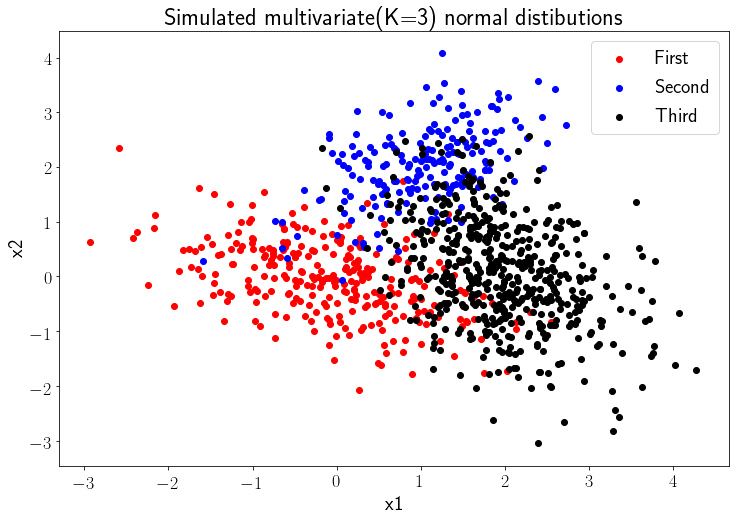

In [20]:
x_g1 = xs[xs[:,2] == 0][:,[0,1]]
x_g2 = xs[xs[:,2] == 1][:,[0,1]]
x_g3 = xs[xs[:,2] == 2][:,[0,1]]

plt.figure(figsize=(12, 8))
plt.scatter(x_g1[:,0], x_g1[:,1], c='r', label='First') 
plt.scatter(x_g2[:,0], x_g2[:,1], c='b', label='Second')
plt.scatter(x_g3[:,0], x_g3[:,1], c='k', label='Third') 
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Simulated multivariate(K=3) normal distibutions ')
plt.show() 

#### 2. Implement the EM algorithm for GMMs

In [21]:
xs_nl = xs[:,:2]  # not labeled data
xs_mean = np.mean(xs_nl, axis=0)
xs_cov = np.cov(xs_nl.T)

# initilize the parameters
pi_para = np.ones((3,1)) / K
us_para = np.array([xs_mean, xs_mean, xs_mean])
sgs = np.array([xs_cov, xs_cov, xs_cov])


In [37]:

ps = pi_para.copy()
us = us_para.copy()
sigmas= sgs.copy()
xs = xs_nl.copy()

log_gamma_ks = cal_log_gamma_ks(K, ps, us, sigmas, xs)
us_new, ps_new, sigmas_new = update_mu_sigma_pi(log_gamma_ks, K, ps, us, sigmas, xs)


In [36]:
print (us, ps)
print (us_new, ps_new)

[[1.18539816 0.42783037]
 [1.18539816 0.42783037]
 [1.18539816 0.42783037]] [[0.33333333]
 [0.33333333]
 [0.33333333]]
[[1.18539816 0.42783037]
 [1.18539816 0.42783037]
 [1.18539816 0.42783037]] [[0.33333333]
 [0.33333333]
 [0.33333333]]


In [73]:
ps = pi_para.copy()
us = us_para.copy()
sigmas= sgs.copy()
xs = xs_nl.copy()

Nr_iter = 10
for it in np.arange(Nr_iter): 
    
    log_gamma_ks = cal_log_gamma_ks(K, ps, us, sigmas, xs)
    us_new, ps_new, sigmas_new = update_mu_sigma_pi(log_gamma_ks, K, ps, us, sigmas, xs)
    
    if it % 3 == 0: 
        print (us, ps)
    
    us = us_new.copy()
    ps =  ps_new.copy()
    sigmas= sigmas_new.copy()
        
    

[[1.18539816 0.42783037]
 [1.18539816 0.42783037]
 [1.18539816 0.42783037]] [[0.33333333]
 [0.33333333]
 [0.33333333]]
[[1.44401195 0.31158829]
 [1.44401195 0.31158829]
 [1.44401195 0.31158829]] [[68.46065833]
 [68.46065833]
 [68.46065833]]


KeyboardInterrupt: 

In [23]:
print (us, ps, sigmas)

[[1.18539816 0.42783037]
 [1.18539816 0.42783037]
 [1.18539816 0.42783037]] [[0.33333333]
 [0.33333333]
 [0.33333333]] [[[ 1.38978939 -0.19955486]
  [-0.19955486  1.39545289]]

 [[ 1.38978939 -0.19955486]
  [-0.19955486  1.39545289]]

 [[ 1.38978939 -0.19955486]
  [-0.19955486  1.39545289]]]




part

Where 
$$ \large \mathcal{N_j} = \mathcal{N}(x;\mu_j, \Sigma_j)= \frac{1}{\sqrt{2\pi}\Sigma_j} \exp{-\frac{(x-\mu_j)^2}{2\Sigma_j^2}} $$
and 

Where 
$$ \large \mathcal{N_j} = \mathcal{N}(x;\mu_j, \Sigma_j)= \frac{1}{\sqrt{2\pi}\Sigma_j} \exp{-\frac{(x-\mu_j)^2}{2\Sigma_j^2}} $$
and 

\begin{align}
f_{\mathbf X}(x_1,\ldots,x_k)
& = \frac{\exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right)}{\sqrt{(2\pi)^k|\boldsymbol\Sigma|}}
\end{align}


$$ \large v_j = \exp({-\frac{(x-\mu_j)^2}{2\Sigma_j^2}}), \kappa_j = \sqrt{2\pi}\Sigma_j, V_{max} = \max_{j} v_j$$

<math>
\begin{align}
f_{\mathbf X}(x_1,\ldots,x_k)
& = \frac{\exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right)}{\sqrt{(2\pi)^k|\boldsymbol\Sigma|}}
\end{align}
</math>

In [24]:
#%&= \large \log (\pi_i {\exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu_j})^\mathrm{T}{\boldsymbol\Sigma_j}^{-1}({\mathbf x}-{\boldsymbol\mu_j})\right)}) - \log({\sqrt{(2\pi)^k|\boldsymbol\Sigma_j|}}) 

In [25]:
# # to be updated
# def stable_logsumexp(xs): 
#     max_xs = np.max(xs)
#     nr_xs = len(xs)
#     vi_vmax = xs - max_xs   
#     return max_xs + np.log(np.sum(np.exp(vi_vmax)))


In [26]:

# log_gamma_ks = cal_log_gamma_ks(K, pi_para , us_para , sgs, xs_nl)

# print (log_gamma_ks)

# us_new, ps_new, sigmas_new = update_mu_sigma_pi(log_gamma_ks, K, pi_para , us_para , sgs, xs_nl)

In [27]:
#     vis = cal_vj (x, u, sigma)
    
#     vj = np.exp((x - uj)**2 / (2)
                
#     multivariate_normal.pdf(x, mean, cov)  
                
    
#     gamma_xk = np.zeros((K,1))
    
#     for i in np.arange(K): 

In [28]:
# #print (us_para)

# # import numpy as np

# # data = np.random.random((5, 2))
# #  # This returns an array of size 500,000 that is the row of 24 values
# # #minimum = data.min(axis=1)
# # minimum = np.array([0, 1, 10, 100, 1000])
# # # print(data.shape, minimum.shape)
# # # print (data, minimum)

# # data1 = data.T * minimum

# # # print (us_para , pi_para , us_new, ps_new )

# # # print (xs_nl)
# # xs_nl - us_new[0,:]

# # diff = xs_nl - us_new[0,:]
# # print (diff[0,:].dot(diff[0,:]))
# # prod = np.outer(diff, diff)
# # print (prod.shape)

# # #sigma_nominater = [np.outer(diff[i,:], diff[i,:]) for i in np.arange(N)]

# # sigma_nominater = [np.exp(log_gamma_ks[0,i]) *np.outer(diff[i,:], diff[i,:]) for i in np.arange(N)]

# # sigma_k = np.sum(sigma_nominater, axis=0)
# # print (np.shape(sigma_nominater), sigma_k)
# # #print (prod.shape)
# #data = np.multiply(data, minimum)

# print (us_new, ps_new, sigmas_new)

In [29]:
# # step 1: initialize

# xs_nl = xs[:,:2]  # not labeled data

# xs_mean = np.mean(xs_nl, axis=0)
# xs_cov = np.cov(xs_nl.T)

# # initilize the parameters
# pi_para = np.ones((3,1)) / K
# us_para = np.array([xs_mean, xs_mean, xs_mean])
# sgs = np.array([xs_cov, xs_cov, xs_cov])


In [30]:
# # step 1: initialize

# xs_nl = xs[:,:2]  # not labeled data

# xs_mean = np.mean(xs_nl, axis=0)
# xs_cov = np.cov(xs_nl.T)

# # initilize the parameters
# pi_para = np.ones((3,1)) / K
# us_para = np.array([xs_mean, xs_mean, xs_mean])
# sgs = np.array([xs_cov, xs_cov, xs_cov])
